In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

torch.Size([50, 2])


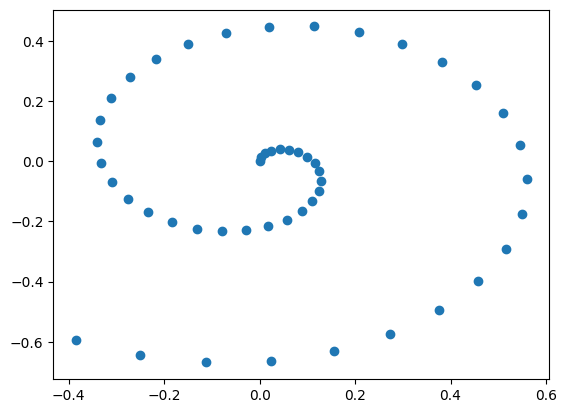

In [88]:
x = np.linspace(0, 10, 50)
X = np.vstack((x * np.sin(x), x * np.cos(x))).T
X = X / (10 * 2 ** 0.5)
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [97]:
class Beta:
    def __init__(self, beta_min=0.1, beta_max=20):
        self.beta_min = beta_min
        self.beta_max = beta_max
    def __call__(self, time):
        # time ranges from 0 to 1
        return self.beta_min + (self.beta_max - self.beta_min) * time
    def integral(self, time):
        return self.beta_min * time + 1/2 * (self.beta_max - self.beta_min) * (time ** 2)

class NoiseScheduler:
    def __init__(self, device="cuda"):
        self.beta = Beta()
        self.device = device
    def get_mean_coefficient(self, t):
        return torch.exp(-1/2 * self.beta.integral(t.view(-1,1)))
    def get_var(self, t):
        return 1 - torch.exp(-self.beta.integral(t.view(-1,1)))
    def get_noised_sample(self, x0, t):
        t = t.view(-1, 1).to(x0.device)
        mean_coefficient = self.get_mean_coefficient(t)
        std = torch.sqrt(self.get_var(t))
        z = torch.randn_like(x0)
        x_t = x0 * mean_coefficient + z * std # x_t
        # gradient_log_probability = -z/std # ground truth
        return x_t, z
    def get_drift_coefficient(self, x, t):
        # f(x,t) = -1/2 * x * beta(t)
        return - 1/2 * x * self.beta(t.view(-1,1))
    def get_diffusion_coefficient(self, t):
        return self.beta(t.view(-1,1)) ** 0.5
    def get_reverse_sde_step(self, x, score, t, dt):
        drift_coefficient = self.get_drift_coefficient(x, t)
        diffusion_coefficient = self.get_diffusion_coefficient(t)
        z = torch.randn_like(x)
        drift = (drift_coefficient - diffusion_coefficient ** 2 * score) * dt
        diffusion = diffusion_coefficient * torch.sqrt(-dt) * z
        dx = drift + diffusion
        x_prev = x + dx
        return x_prev
    def get_langevin_update(self, x, score, t, dt):
        z = torch.randn_like(x)
        drift = dt * score
        noise = torch.sqrt(2 * dt) * z
        x_prev = x + drift + noise
        return x_prev
    def get_examples(self, num_examples, X):
        examples = []
        times = torch.rand(num_examples)
        for i in range(num_examples):
            idx = torch.randint(0, X.shape[0], (1,))
            # format: ((x_t, grad_logprob), t)
            examples.append((self.get_noised_sample(X[idx], times[i]), times[i]))
        return examples
        

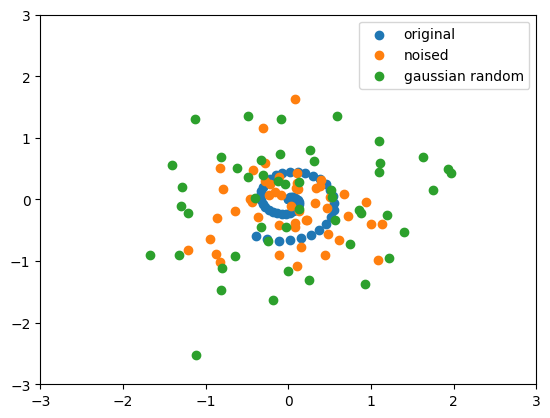

In [98]:
noise_scheduler = NoiseScheduler("cpu")
X_new, score = noise_scheduler.get_noised_sample(X, torch.tensor(0.15))
plt.scatter(X[:, 0], X[:, 1], label="original")
plt.scatter(X_new[:, 0], X_new[:, 1], label="noised")
random_data = torch.randn_like(X_new)
plt.scatter(random_data[:,0], random_data[:, 1], label="gaussian random")
plt.legend()
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [ ]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, time_dim=32):
        super().__init__()
        self.dim = time_dim
    def forward(self, t):
        t = t.view(-1, 1)
        exponents = torch.arange(self.dim // 2, device=t.device, dtype=torch.float32)
        exponents = exponents / (self.dim // 2 - 1)
        freqs = torch.exp(-torch.log(torch.tensor(10000.0)) * exponents)
        args = t * freqs.view(1, -1)
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

class ResBlock(nn.Module):
    def __init__(self, n_hidden, time_dim):
        super().__init__()
        self.time_proj = nn.Linear(time_dim, n_hidden)
        self.linear1 = nn.Linear(n_hidden, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.silu = nn.SiLU()

    def forward(self, x, t_emb):
        x_res = x
        t = self.silu(self.time_proj(t_emb))
        out = self.linear1(x)
        out = out + t.view(-1, out.shape[1])
        out = self.silu(out)
        out = self.linear2(out)
        return out + x_res

# --- The new, more powerful network ---
class NeuralNetwork(nn.Module):
    def __init__(self, n_features=2, time_dim=64, n_hidden=128):
        super().__init__()
        self.time_embedding = SinusoidalTimeEmbedding(time_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        self.input_proj = nn.Linear(n_features, n_hidden)
        self.block1 = ResBlock(n_hidden, time_dim)
        self.block2 = ResBlock(n_hidden, time_dim)
        self.block3 = ResBlock(n_hidden, time_dim)
        self.output_proj = nn.Linear(n_hidden, n_features)

    def forward(self, x_t, t):
        t_emb = self.time_embedding(t)
        t_emb = self.t_proj(t_emb)
        x_out = self.input_proj(x_t)
        x_out = self.block1(x_out, t_emb)
        x_out = self.block2(x_out, t_emb)
        x_out = self.block3(x_out, t_emb)
        
        return self.output_proj(x_out)

class DiffusionDataset(Dataset):
    def __init__(self, x0s):
        self.data = x0s.to(dtype=torch.float32)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        return self.data[index]

In [126]:
device = "cpu"
X_dataset = X.repeat(200, 1).to(device, dtype=torch.float32)
train_dataset = DiffusionDataset(X_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
model = NeuralNetwork()
mse_loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 2000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [127]:
losses = []
for epoch in range(num_epochs):
    running_loss = 0
    counter = 0
    for batch in train_dataloader:
        x0 = batch.to(device)
        batch_size = x0.shape[0]
        t = torch.rand(batch_size, device=device) * (1.0 - 1e-5) + 1e-5
        x_t, z = noise_scheduler.get_noised_sample(x0, t)
        prediction = model(x_t, t)
        loss = mse_loss(prediction, z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        counter += 1
    average_loss = running_loss / counter
    losses.append(average_loss)
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Average Loss: {average_loss}")
    scheduler.step()

Epoch 0, Average Loss: 0.1990078091621399
Epoch 100, Average Loss: 0.11760804802179337
Epoch 200, Average Loss: 0.09951069205999374
Epoch 300, Average Loss: 0.10743667185306549
Epoch 400, Average Loss: 0.09721752256155014
Epoch 500, Average Loss: 0.09716616570949554
Epoch 600, Average Loss: 0.09660099446773529
Epoch 700, Average Loss: 0.09633121639490128


KeyboardInterrupt: 

In [128]:
@torch.no_grad()
def generate_samples(model, noise_scheduler, num_samples, num_steps, device):
    model.eval()
    x_t = torch.randn(num_samples,2).to(device)
    timesteps = torch.linspace(1.0, 1e-5, num_steps).to(device)
    for i in range(num_steps - 1):
        t = timesteps[i]
        t_next = timesteps[i + 1]
        dt = t_next - t
        t_batch = torch.full((num_samples,), t).to(device)
        predicted_noise = model(x_t, t_batch)
        var_t = noise_scheduler.get_var(t_batch.view(-1, 1))
        std_t = torch.sqrt(var_t)
        predicted_score = - predicted_noise / std_t
        x_t = noise_scheduler.get_reverse_sde_step(x_t, predicted_score, t_batch, dt)
        if i % 10 == 0 or i == num_steps - 2:
            print(f"Step {i + 1} / {num_steps}")
    print("Generation complete.")
    model.train()
    return x_t.detach().cpu()

Step 1 / 1000
Step 11 / 1000
Step 21 / 1000
Step 31 / 1000
Step 41 / 1000
Step 51 / 1000
Step 61 / 1000
Step 71 / 1000
Step 81 / 1000
Step 91 / 1000
Step 101 / 1000
Step 111 / 1000
Step 121 / 1000
Step 131 / 1000
Step 141 / 1000
Step 151 / 1000
Step 161 / 1000
Step 171 / 1000
Step 181 / 1000
Step 191 / 1000
Step 201 / 1000
Step 211 / 1000
Step 221 / 1000
Step 231 / 1000
Step 241 / 1000
Step 251 / 1000
Step 261 / 1000
Step 271 / 1000
Step 281 / 1000
Step 291 / 1000
Step 301 / 1000
Step 311 / 1000
Step 321 / 1000
Step 331 / 1000
Step 341 / 1000
Step 351 / 1000
Step 361 / 1000
Step 371 / 1000
Step 381 / 1000
Step 391 / 1000
Step 401 / 1000
Step 411 / 1000
Step 421 / 1000
Step 431 / 1000
Step 441 / 1000
Step 451 / 1000
Step 461 / 1000
Step 471 / 1000
Step 481 / 1000
Step 491 / 1000
Step 501 / 1000
Step 511 / 1000
Step 521 / 1000
Step 531 / 1000
Step 541 / 1000
Step 551 / 1000
Step 561 / 1000
Step 571 / 1000
Step 581 / 1000
Step 591 / 1000
Step 601 / 1000
Step 611 / 1000
Step 621 / 1000
Ste

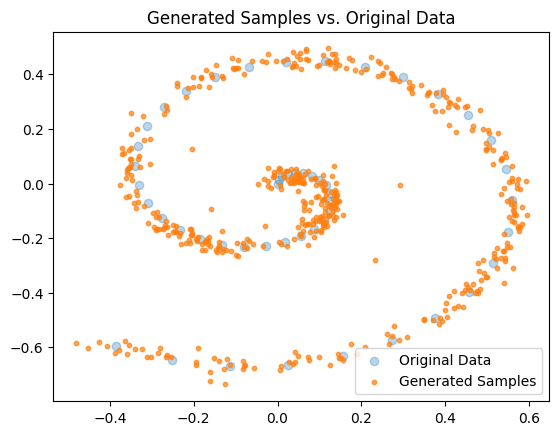

In [132]:
num_gen_samples = 500
num_gen_steps = 1000
generated_samples = generate_samples(
    model, 
    noise_scheduler, 
    num_gen_samples, 
    num_gen_steps, 
    device
)

plt.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), label="Original Data", alpha=0.3)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label="Generated Samples", alpha=0.7, s=10)
plt.legend()
plt.title("Generated Samples vs. Original Data")
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.show()